# Music Genre Classification

Using different algorithms and inputs to accurately classify music genres from audio samples

# USE KFOLD for future
https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/


### Packages

In [1]:
import os
import cv2
from tensorflow import keras
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
import pandas as pd

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
from sklearn.preprocessing import OneHotEncoder

#### Global Variables

In [4]:
GTZAN = {'nGenres': 10, 'genres': ['blues', 'classical', 'country', 'disco', 'hiphop', 
                                   'jazz', 'metal', 'pop', 'reggae', 'rock']}
EXTENDED_BALLROOM = {'nGenres': 9, 'genres': ['chacha', 'foxtrot', 'jive', 'quickstep', 'rumba',
                                              'samba', 'tango', 'viennesewaltz', 'waltz']}
FEATURES = ('stft', 'mfcc', 'melspectrogram', 'fouriertempogram')
RNG_STATE = 422
TEST_SIZE = 0.2
EPOCHS = 50
BATCH_SIZE = 64

# make model csv file to save stats
MODEL_COLS = ["Model Name", "Method", "Dataset", "Feature", "Split", "Test Accuracy", "Test Loss",
                                     "Train Accuracy", "Train Loss", "Best Epoch", "Validation Accuracy",
                                     "Validation Loss", "Training Accuracy", "Training Loss"]
MODEL_STATS = pd.DataFrame(columns = MODEL_COLS)
if not os.path.exists('models/models.csv'): # if not already made
    print("Created models.csv")
    MODEL_STATS.to_csv(r'models/models.csv', index = False)

### Helper Methods

In [5]:
def getFeatures(dataset, feature, split):
    # LOADING
    X = np.load(os.path.join(os.getcwd(), "datasets", dataset, "features", f"{feature}{split}-X.npy"))
    Y = np.load(os.path.join(os.getcwd(), "datasets", dataset, "features", f"{feature}{split}-Y.npy"))
    #SPLITTING
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = RNG_STATE, 
                                                        stratify = Y)
    
    return (X_train, X_test, Y_train, Y_test)

In [6]:
def cnf_matrix():
    plt.figure(figsize=(11,11))
    cm = sklearn.metrics.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(m.predict(X_test), axis=-1))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(list(range(10)), ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
    plt.yticks(list(range(10)), ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
    plt.title('Confusion matrix for DCNN model')
    plt.xlabel('Predicted genre')
    plt.ylabel('True genre')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

In [7]:
def plot_graph(history, title, download = True):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    if download:
        plt.savefig(f'models/graphs/{name}-Accuracy.png')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    if download:
        plt.savefig(f'models/graphs/{name}-Loss.png')
    plt.show()

In [8]:
def get_res(history, epoch):
    h = history.history
    train_acc = h['categorical_accuracy'][epoch - 1]
    val_acc = h['val_categorical_accuracy'][epoch - 1]
    train_loss = h['loss'][epoch - 1]
    val_loss = h['val_loss'][epoch - 1]
    #print(train_acc, val_acc, train_loss, val_loss)
    
    return train_acc, train_loss, val_acc, val_loss

# Processing

Librosa for feature extraction of audio files\
STFT | MFCC | Melspectrogram | Fourier Tempogram

GTZAN (10 Genres)\
Extended Ballroom (9 Genres - removed 4 for having less than 100 samples)

In [237]:
def process(dataset, feature, time_split, verbose = False, save = False):
    N_FFT = 2048
    HOP_LENGTH = 1024
    N_MELS = 64
    N_MFCC = 13
    
    processed = []
    processed_genres = []
    
    feature = feature.lower()
    aud_path = os.path.join(os.getcwd(), "datasets", dataset, "audio")
    if not os.path.exists(aud_path):
        print("Dataset not found:", aud_path)
        return
        
    features = ("stft", "melspectrogram", "mfcc", "fouriertempogram")
    TOTAL_GENRES = len(os.listdir(aud_path))

    if feature not in features:
        print(f"{feature} not available for extraction")
        return
    
    feat_path = os.path.join(os.getcwd(), "datasets", dataset, "features")
    os.path.isdir(feat_path) or os.makedirs(feat_path)
    
    currentGenre = 0
    for folder in os.listdir(aud_path):
        folder_path = os.path.join(aud_path, folder)
        for audio in os.listdir(folder_path):  
            audio_path = os.path.join(folder_path, audio)
            y, sr = librosa.load(audio_path) # can user offset and duration for 5 second intervals
            if feature == "stft":
                feat = np.abs(librosa.stft(y, hop_length = HOP_LENGTH, n_fft = N_FFT))
            elif feature == "mfcc":
                feat = librosa.feature.mfcc(y = y, sr = sr, hop_length = HOP_LENGTH, 
                                                      n_fft = N_FFT)
            elif feature == "melspectrogram":
                feat = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = N_MELS, n_fft = N_FFT,
                                                     hop_length = HOP_LENGTH)
            elif feature == "fouriertempogram":
                oenv = librosa.onset.onset_strength(y = y, sr = sr, hop_length = HOP_LENGTH)
                feat = librosa.feature.fourier_tempogram(onset_envelope = oenv, sr = sr, hop_length = HOP_LENGTH)
                #feat = librosa.feature.tempogram(onset_envelope = oenv, sr = sr, hop_length = HOP_LENGTH)
            feat = librosa.power_to_db(feat ** 2) # feat ** 2 for amplitude to db
            #if len(feat[0]) != 647:
            #    print(len(feat[0]))
            #print(feat.shape)
            #print(feat[:2, :512].shape)
            #librosa.display.specshow(feat[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #print(feat.shape)
            
            # max is (x, 647) or (x, 648) -- imma treat max as 640 -- can be //10,8,5,4,2 -> 3, 3.75, 6, 7.5, 15
            out = feat[:, :640]

            # split into segments -- 3, 3.75, 6, 7.5, 15 seconds
            out_split = np.hsplit(out, time_split)
            for split in out_split:
                #print(split.shape)
                processed.append(split)
                # one hot encoding
                processed_genres.append([1 if i == currentGenre else 0 for i in range(TOTAL_GENRES)])
                #librosa.display.specshow(split[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #print(len(out_split))
            #librosa.display.specshow(out[:, :], sr=sr, hop_length = HOP_LENGTH)
        currentGenre += 1
        if verbose:
            print(folder, "complete;", feature, processed[0].shape)
    
    X = np.array(processed)
    Y = np.array(processed_genres)
    
    
    if save:
        #np.save(os.path.join(feat_path, f"{feature + str(time_split)}-X.npy"), X)
        #np.save(os.path.join(feat_path, f"{feature + str(time_split)}-Y.npy"), Y)
        pass
    
    return X, Y

### Run to extract features if have not done so already

Extracting features from Extended Ballroom taks a while, 10x+ longer than GTZAN

Processing GTZAN with total genres of 10
	melspectrogram with splits (1,) took 0.04217649999191053 seconds


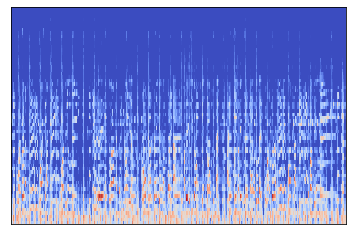

In [242]:
#features = ("stft", "melspectrogram", "mfcc", "fouriertempogram",)
features = ("melspectrogram",)
#datasets = ("GTZAN", "Extended Ballroom",)
datasets = ('GTZAN',)
splits = (10, 8, 5, 4, 2, 1)
splits = (1, )
for dataset in datasets:
    print("Processing", dataset, "with total genres of", 
              len(os.listdir(os.path.join(os.getcwd(), "datasets", dataset, "audio"))))
    for feature in features:
        start = time.perf_counter()
        for split in splits:
            process(dataset, feature, split, verbose = True, save = True)
        print(f"\t{feature} with splits", str(splits), "took", time.perf_counter() - start, "seconds")

### References

yang2020parallel
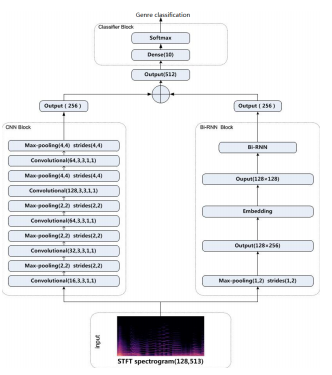

## CNN

Explain general structure of what i did

### STFT (1025, 640)

In [35]:
def conv_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    x = BatchNormalization()(x) # should do this
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [36]:
def CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = conv_block(inpt, n_filters = 16, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (4, 4), pool_size = (4, 4))
    
    x = conv_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name) # can add name
    return model

#### GTZAN

In [75]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'STFT'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
# Model
m = CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "594_CNN_STFT_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1025, 64, 1)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1025, 64, 16)      160       
_________________________________________________________________
batch_normalization_35 (Batc (None, 1025, 64, 16)      64        
_________________________________________________________________
activation_35 (Activation)   (None, 1025, 64, 16)      0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 512, 32, 16)       0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 512, 32, 16)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 512, 32, 

In [76]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
100/100 [==============================] - 243s 2s/step - loss: 6.9543 - categorical_accuracy: 0.2006 - val_loss: 4.7520 - val_categorical_accuracy: 0.2731
Epoch 2/100
100/100 [==============================] - 240s 2s/step - loss: 4.2141 - categorical_accuracy: 0.3641 - val_loss: 3.2429 - val_categorical_accuracy: 0.4244
Epoch 3/100
100/100 [==============================] - 242s 2s/step - loss: 2.8888 - categorical_accuracy: 0.4491 - val_loss: 2.5734 - val_categorical_accuracy: 0.3600
Epoch 4/100
100/100 [==============================] - 242s 2s/step - loss: 2.2273 - categorical_accuracy: 0.4926 - val_loss: 2.1730 - val_categorical_accuracy: 0.4137
Epoch 5/100
100/100 [==============================] - 242s 2s/step - loss: 1.8358 - categorical_accuracy: 0.5410 - val_loss: 1.8596 - val_categorical_accuracy: 0.4756
Epoch 6/100
100/100 [==============================] - 242s 2s/step - loss: 1.5894 - categorical_accuracy: 0.5693 - val_loss: 1.5655 - val_categorical_accuracy:

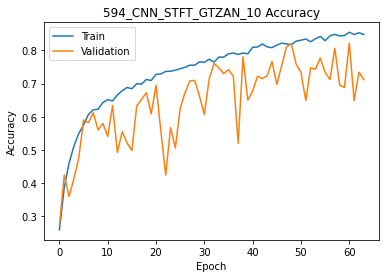

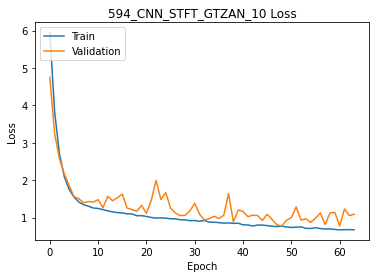

In [77]:
plot_graph(history, name) # should save the graphs as well

In [78]:
best_epoch = 49
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [79]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

250/250 [==============================] - 39s 154ms/step - loss: 0.6409 - categorical_accuracy: 0.8789
Loss: 0.6409105658531189
Train Accuracy: 0.8788750171661377


In [80]:
test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

63/63 [==============================] - 10s 149ms/step - loss: 0.7763 - categorical_accuracy: 0.8250
Loss: 0.7762635946273804
Test Accuracy: 0.824999988079071


In [81]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

Bro training takes so long for this... 1200s per epoch

In [118]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split =10
mod = 'CNN'
feat = 'STFT'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("EXTENDED BALLROOM", feat, split)
# Model
m = CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "6968_CNN_STFT_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1025, 64, 1)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1025, 64, 16)      160       
_________________________________________________________________
batch_normalization_65 (Batc (None, 1025, 64, 16)      64        
_________________________________________________________________
activation_65 (Activation)   (None, 1025, 64, 16)      0         
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 512, 32, 16)       0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 512, 32, 16)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (Non

In [119]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
400/400 [==============================] - 1024s 3s/step - loss: 5.1641 - categorical_accuracy: 0.2600 - val_loss: 3.1425 - val_categorical_accuracy: 0.2311
Epoch 2/100
400/400 [==============================] - 1017s 3s/step - loss: 1.6388 - categorical_accuracy: 0.5430 - val_loss: 1.8515 - val_categorical_accuracy: 0.4618
Epoch 3/100
400/400 [==============================] - 1010s 3s/step - loss: 1.0749 - categorical_accuracy: 0.7041 - val_loss: 1.2034 - val_categorical_accuracy: 0.6356
Epoch 4/100
400/400 [==============================] - 1003s 3s/step - loss: 0.9294 - categorical_accuracy: 0.7494 - val_loss: 0.8039 - val_categorical_accuracy: 0.7888
Epoch 5/100
400/400 [==============================] - 1001s 3s/step - loss: 0.8404 - categorical_accuracy: 0.7744 - val_loss: 1.0328 - val_categorical_accuracy: 0.7044
Epoch 6/100
400/400 [==============================] - 1002s 3s/step - loss: 0.8064 - categorical_accuracy: 0.7875 - val_loss: 0.8423 - val_categorical_acc

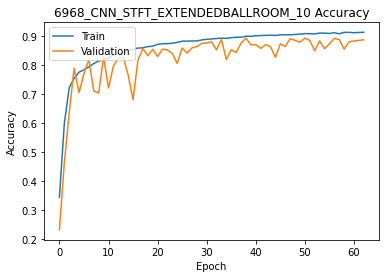

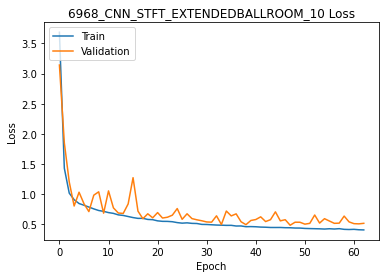

In [120]:
plot_graph(history, name) 

In [121]:
best_epoch = 48
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [122]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

998/998 [==============================] - 181s 181ms/step - loss: 0.3530 - categorical_accuracy: 0.9345
Loss: 0.35299474000930786
Train Accuracy: 0.9344626665115356


In [123]:
test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

250/250 [==============================] - 46s 183ms/step - loss: 0.4628 - categorical_accuracy: 0.8947
Loss: 0.4628380835056305
Test Accuracy: 0.8946643471717834


In [124]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### MFCC (20, 640)

In [8]:
def MFCC_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size, dropout = None):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    if dropout:
        x = Dropout(dropout)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [9]:
def MFCC_CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = MFCC_block(inpt, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name)
    return model

#### GTZAN

Model: "5027_CNN_MFCC_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20, 64, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 64, 32)        320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 64, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 20, 64, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 32, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 10, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 32, 

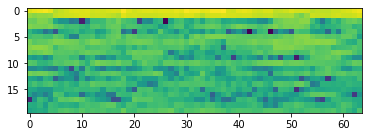

In [45]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MFCC'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MFCC_CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [46]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
100/100 [==============================] - 9s 81ms/step - loss: 5.2634 - categorical_accuracy: 0.1583 - val_loss: 6.8743 - val_categorical_accuracy: 0.0869
Epoch 2/100
100/100 [==============================] - 8s 80ms/step - loss: 3.4610 - categorical_accuracy: 0.3194 - val_loss: 4.5137 - val_categorical_accuracy: 0.1231
Epoch 3/100
100/100 [==============================] - 8s 79ms/step - loss: 2.5701 - categorical_accuracy: 0.3965 - val_loss: 2.2854 - val_categorical_accuracy: 0.3750
Epoch 4/100
100/100 [==============================] - 8s 79ms/step - loss: 2.1054 - categorical_accuracy: 0.4299 - val_loss: 2.0151 - val_categorical_accuracy: 0.3875
Epoch 5/100
100/100 [==============================] - 8s 78ms/step - loss: 1.8277 - categorical_accuracy: 0.4531 - val_loss: 1.7973 - val_categorical_accuracy: 0.4294
Epoch 6/100
100/100 [==============================] - 8s 78ms/step - loss: 1.6596 - categorical_accuracy: 0.4788 - val_loss: 1.8002 - val_categorical_accuracy:

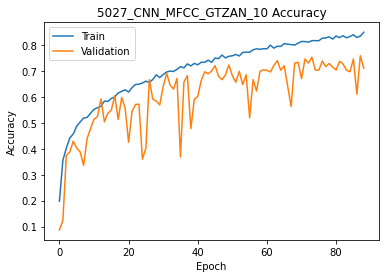

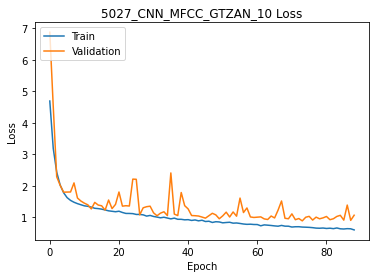

In [47]:
plot_graph(history, name)

In [48]:
best_epoch = 74
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [49]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.4913 - categorical_accuracy: 0.9100
Loss: 0.4912721812725067
Train Accuracy: 0.9100000262260437


In [50]:
test = m.evaluate(X_test, Y_test)
#print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

63/63 [==============================] - 1s 9ms/step - loss: 0.8779 - categorical_accuracy: 0.7590
Loss: 0.8778737187385559
Test Accuracy: 0.7590000033378601


In [51]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

Model: "8789_CNN_MFCC_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 20, 64, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 20, 64, 32)        320       
_________________________________________________________________
batch_normalization_44 (Batc (None, 20, 64, 32)        128       
_________________________________________________________________
activation_44 (Activation)   (None, 20, 64, 32)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 10, 32, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 10, 32, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (Non

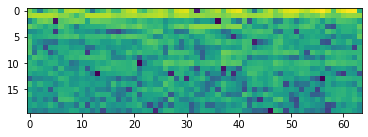

In [87]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MFCC'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("EXTENDED BALLROOM", "mfcc", split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MFCC_CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [88]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
400/400 [==============================] - 33s 81ms/step - loss: 4.1491 - categorical_accuracy: 0.2125 - val_loss: 2.1803 - val_categorical_accuracy: 0.2722
Epoch 2/100
400/400 [==============================] - 32s 80ms/step - loss: 1.9553 - categorical_accuracy: 0.3191 - val_loss: 1.7860 - val_categorical_accuracy: 0.3333
Epoch 3/100
400/400 [==============================] - 32s 80ms/step - loss: 1.7460 - categorical_accuracy: 0.3461 - val_loss: 1.8352 - val_categorical_accuracy: 0.3071
Epoch 4/100
400/400 [==============================] - 32s 80ms/step - loss: 1.7044 - categorical_accuracy: 0.3584 - val_loss: 1.7376 - val_categorical_accuracy: 0.3439
Epoch 5/100
400/400 [==============================] - 32s 80ms/step - loss: 1.6678 - categorical_accuracy: 0.3835 - val_loss: 2.0169 - val_categorical_accuracy: 0.2793
Epoch 6/100
400/400 [==============================] - 32s 80ms/step - loss: 1.5990 - categorical_accuracy: 0.4242 - val_loss: 1.7484 - val_categorical_acc

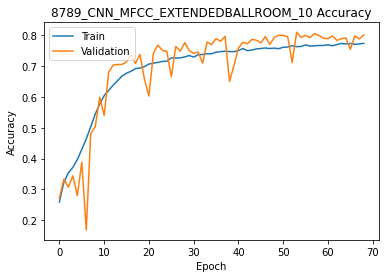

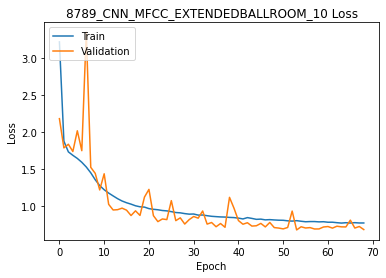

In [89]:
plot_graph(history, name)

In [90]:
best_epoch = 54
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [91]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

998/998 [==============================] - 9s 9ms/step - loss: 0.5662 - categorical_accuracy: 0.8530
Loss: 0.566166877746582
Train Accuracy: 0.8529872298240662


In [92]:
test = m.evaluate(X_test, Y_test)
#print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.6821 - categorical_accuracy: 0.8054
Loss: 0.6821264624595642
Test Accuracy: 0.805360734462738


In [93]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### Melspectrogram (64, 640)

In [8]:
def mel_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [9]:
def MEL_CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = mel_block(inpt, n_filters = 16, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (4, 4), pool_size = (4, 4))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name)
    return model

#### GTZAN

Model: "9658_CNN_MELSPECTROGRAM_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None

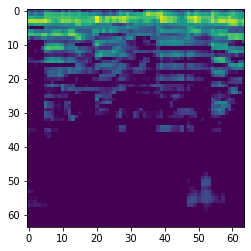

In [12]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MELSPECTROGRAM'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MEL_CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [13]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
100/100 [==============================] - 8s 77ms/step - loss: 7.9190 - categorical_accuracy: 0.1260 - val_loss: 5.0874 - val_categorical_accuracy: 0.1912
Epoch 2/100
100/100 [==============================] - 7s 68ms/step - loss: 4.6946 - categorical_accuracy: 0.2326 - val_loss: 4.0544 - val_categorical_accuracy: 0.3119
Epoch 3/100
100/100 [==============================] - 7s 70ms/step - loss: 3.6926 - categorical_accuracy: 0.3194 - val_loss: 3.2036 - val_categorical_accuracy: 0.3850
Epoch 4/100
100/100 [==============================] - 7s 71ms/step - loss: 2.9837 - categorical_accuracy: 0.3882 - val_loss: 2.8590 - val_categorical_accuracy: 0.3063
Epoch 5/100
100/100 [==============================] - 7s 69ms/step - loss: 2.4886 - categorical_accuracy: 0.4289 - val_loss: 2.4329 - val_categorical_accuracy: 0.3688
Epoch 6/100
100/100 [==============================] - 7s 68ms/step - loss: 2.1330 - categorical_accuracy: 0.4816 - val_loss: 2.0787 - val_categorical_accuracy:

100/100 [==============================] - 7s 68ms/step - loss: 0.8060 - categorical_accuracy: 0.7905 - val_loss: 0.7195 - val_categorical_accuracy: 0.8044
Epoch 98/100
100/100 [==============================] - 7s 68ms/step - loss: 0.7658 - categorical_accuracy: 0.7990 - val_loss: 0.6814 - val_categorical_accuracy: 0.8313
Epoch 99/100
100/100 [==============================] - 7s 68ms/step - loss: 0.7716 - categorical_accuracy: 0.8018 - val_loss: 0.6800 - val_categorical_accuracy: 0.8431
Epoch 100/100
100/100 [==============================] - 7s 69ms/step - loss: 0.7479 - categorical_accuracy: 0.7996 - val_loss: 0.7196 - val_categorical_accuracy: 0.8238


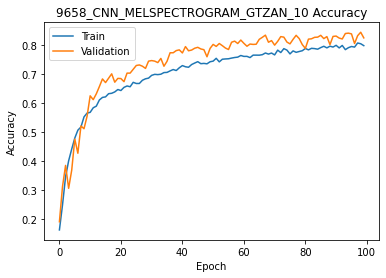

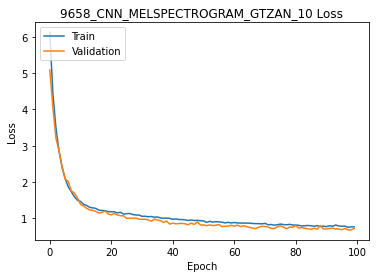

In [14]:
plot_graph(history, name)

In [15]:
best_epoch = 98
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [16]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.5251 - categorical_accuracy: 0.9035
Loss: 0.52506422996521
Train Accuracy: 0.9035000205039978


In [17]:
test = m.evaluate(X_test, Y_test)
print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

63/63 [==============================] - 1s 10ms/step - loss: 0.6946 - categorical_accuracy: 0.8330
(2000, 64, 64)
Loss: 0.6946128606796265
Test Accuracy: 0.8330000042915344


In [18]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

(31936, 64, 64)
Model: "9243_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activat

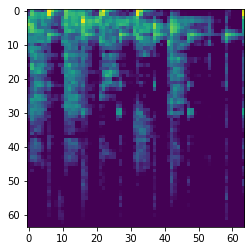

In [31]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MELSPECTROGRAM'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("Extended Ballroom", feat, split)
print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MEL_CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [32]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
400/400 [==============================] - 30s 72ms/step - loss: 5.5513 - categorical_accuracy: 0.1783 - val_loss: 2.6777 - val_categorical_accuracy: 0.3073
Epoch 2/100
400/400 [==============================] - 28s 71ms/step - loss: 2.3837 - categorical_accuracy: 0.3148 - val_loss: 1.9566 - val_categorical_accuracy: 0.3735
Epoch 3/100
400/400 [==============================] - 28s 71ms/step - loss: 1.8175 - categorical_accuracy: 0.3784 - val_loss: 1.7617 - val_categorical_accuracy: 0.4065
Epoch 4/100
400/400 [==============================] - 28s 71ms/step - loss: 1.6488 - categorical_accuracy: 0.4348 - val_loss: 1.4712 - val_categorical_accuracy: 0.5343
Epoch 5/100
400/400 [==============================] - 28s 70ms/step - loss: 1.4777 - categorical_accuracy: 0.5048 - val_loss: 1.2827 - val_categorical_accuracy: 0.6168
Epoch 6/100
400/400 [==============================] - 28s 71ms/step - loss: 1.3830 - categorical_accuracy: 0.5552 - val_loss: 1.2264 - val_categorical_acc

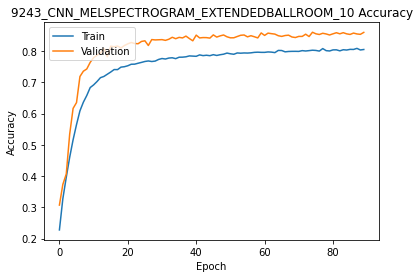

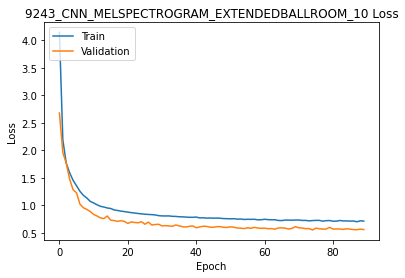

In [33]:
plot_graph(history, name)

In [34]:
best_epoch = 75
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [35]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

998/998 [==============================] - 10s 10ms/step - loss: 0.4859 - categorical_accuracy: 0.8831
Loss: 0.48590248823165894
Train Accuracy: 0.8830786347389221


In [36]:
test = m.evaluate(X_test, Y_test)
#print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

250/250 [==============================] - 2s 10ms/step - loss: 0.5653 - categorical_accuracy: 0.8506
Loss: 0.5652881860733032
Test Accuracy: 0.8505761623382568


In [37]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

# Base Results

In the results below, Train Accuracy and Training Accuracy are different. Training Accuracy is the training accuracy from the resulting best epoch, while the Train Accuracy is basically the overall train accuracy of the model. 

Shows only splits 5, 8, 10

In [48]:
MODELS_PATH = os.path.join(os.getcwd(), 'models', 'models.csv')
MODELS = pd.read_csv(MODELS_PATH).set_index("Model Name")
MODELS = MODELS.sort_values('Test Accuracy', ascending = False)
MODELS = MODELS[MODELS['Split'].isin([5, 8, 10])]
MODELS

,Method,Dataset,Feature,Split,Test Accuracy,Test Loss,Train Accuracy,Train Loss,Best Epoch,Validation Accuracy,Validation Loss,Training Accuracy,Training Loss
Model Name,,,,,,,,,,,,,
4734_CNN_STFT_MFCC_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,"STFT, MFCC",8,0.913118,0.453004,0.965203,0.290492,19,0.905088,0.478700,0.939035,0.352757
5948_CNN_STFT_MELSPECTROGRAM_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,"STFT, MELSPECTROGRAM",8,0.911240,0.463117,0.963520,0.301144,15,0.906262,0.480903,0.933066,0.382799
3857_CNN_STFT_MFCC_GTZAN_8,CNN,GTZAN,"STFT, MFCC",8,0.908750,0.541071,0.974219,0.341422,30,0.893750,0.562724,0.941602,0.405900
5031_CNN_STFT_MELSPECTROGRAM_GTZAN_8,CNN,GTZAN,"STFT, MELSPECTROGRAM",8,0.905625,0.555994,0.970625,0.370765,18,0.898438,0.568121,0.938086,0.447174
3375_CNN_STFT_EXTENDEDBALLROOM_5,CNN,ExtendedBallroom,STFT,5,0.903808,0.492371,0.945140,0.365856,39,0.910770,0.472410,0.926570,0.398633
7137_CNN_STFT_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,STFT,8,0.903413,0.473348,0.947432,0.318092,53,0.895499,0.492155,0.923329,0.383254
6968_CNN_STFT_EXTENDEDBALLROOM_10,CNN,ExtendedBallroom,STFT,10,0.894664,0.462838,0.934463,0.352995,48,0.891046,0.484993,0.903867,0.443369
5461_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_5,CNN,ExtendedBallroom,MELSPECTROGRAM,5,0.894289,0.490980,0.930173,0.379099,75,0.900751,0.461575,0.866291,0.575260
6448_CNN_MFCC_MELSPECTROGRAM_GTZAN_8,CNN,GTZAN,"MFCC, MELSPECTROGRAM",8,0.891875,0.556453,0.969531,0.344940,40,0.882812,0.568622,0.903711,0.500308


In [116]:
for i in [1, 2, 4, 5, 8, 10]:
    test_a = MODELS[MODELS["Split"] == i]["Test Accuracy"].mean()
    train_a = MODELS[MODELS["Split"] == i]["Train Accuracy"].mean()
    v = MODELS[MODELS["Split"] == i]["Validation Loss"].mean()
    print(f"{i} split: Avg test Accuracy: {test_a:.3f}, Avg train Accuracy: {train_a:.3f}, Avg validation Loss: {v:.3f}")

1 split: Avg test Accuracy: 0.622, Avg train Accuracy: 0.700, Avg validation Loss: 1.513
2 split: Avg test Accuracy: 0.712, Avg train Accuracy: 0.805, Avg validation Loss: 1.303
4 split: Avg test Accuracy: 0.837, Avg train Accuracy: 0.899, Avg validation Loss: 0.701
5 split: Avg test Accuracy: 0.821, Avg train Accuracy: 0.895, Avg validation Loss: 0.663
8 split: Avg test Accuracy: 0.832, Avg train Accuracy: 0.893, Avg validation Loss: 0.684
10 split: Avg test Accuracy: 0.828, Avg train Accuracy: 0.894, Avg validation Loss: 0.676


### With the results above, I decided to use Split of 8s due to having more sample sizes which would lead to less overfitting and still having a high enough test accuracy.

In [1]:
# confusion matrix and visualization

# Parallelization
STFT, MFCC, Melspectrogram\
Random Forest, SVM, Logistic Regression, PCA, K-means clustering, nearest neighbor, naive bayes classifier

jeong2016learning
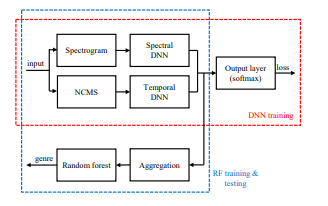

In [11]:
def classical_parallel_model(model1, train1, model2, train2, num_genres, name, classifier):
    # layer name need to be unique
    i = 0
    for layer in model1.layers:
        layer._name += f"_{i}"
        i += 1
    for layer in model2.layers:
        layer._name += f"_{i}"
        i += 1
    
    m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
    m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
    m1 = Model(inputs = model1.input, outputs = m1_layer)
    m2 = Model(inputs = model2.input, outputs = m2_layer)

    # feature extraction
    m1_output = m1.predict(train1)
    m2_output = m2.predict(train2)
    output_features = np.column_stack((m1_output, m2_output)) # concatenation
    #output_features = m1_output

    # testing
    testing_m1_output = m1.predict(X_test1)
    testing_m2_output = m2.predict(X_test2)
    testing_output_features = np.column_stack((testing_m1_output, testing_m2_output)) # concatenation

    notOHE = [np.argmax(x) for x in Y_train2] # inverse one hot encoding
    notOHEtest = [np.argmax(x) for x in Y_test1]

    if classifier == 'rf':
        params = {
            "cls__n_estimators": [100, 250, 500, 1000],
            "cls__criterion": ["gini", "entropy"],
            "cls__max_depth": [5, 7, None]
        }

        pipe_rf = Pipeline([
            ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
            ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
            ('cls', RandomForestClassifier())
        ])

        grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=3, cv=5, verbose = 3)
        grid_rf.fit(output_features, notOHE)
        print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))

        preds = grid_rf.predict(testing_output_features)
        print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(preds, notOHEtest)))
    
    elif classifier == 'lr':
        params = {
            "cls__penalty": ["l1", "l2"],
            "cls__C": [0.5, 1, 2, 5],
            "cls__max_iter": [500]
        }

        pipe_lr = Pipeline([
            ('scale', StandardScaler()),
            ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
            ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
            ('cls', LogisticRegression())
        ])

        grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=3, cv=5, verbose = 3)
        grid_lr.fit(output_features, notOHE)
        print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))

        preds = grid_lr.predict(testing_output_features)
        print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(preds, notOHEtest)))

    elif classifier == 'svm':
        params = {
            "cls__C": [0.5, 1, 2, 5],
            "cls__kernel": ['rbf', 'linear', 'sigmoid'],
        }

        pipe_svm = Pipeline([
            ('scale', StandardScaler()),
            ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
            ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
            ('cls', SVC())
        ])

        grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=3, cv=5, verbose = 3)
        grid_svm.fit(output_features, notOHE)
        print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
        
        preds = grid_svm.predict(output_features)
        print("best score on training set (accuracy) = {:.4f}".format(accuracy_score(preds, notOHE)))

        preds = grid_svm.predict(testing_output_features)
        print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(preds, notOHEtest)))
        
    elif classifier == 'knn':
        pass

In [12]:
def parallel_model(model1, model2, num_genres, name):
    # layer name need to be unique
    i = 0
    for layer in model1.layers:
        layer._name += f"_{i}"
        i += 1
    for layer in model2.layers:
        layer._name += f"_{i}"
        i += 1
    
    # get flattened layer for each
    m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
    m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
    
    # Merged models
    merged = Concatenate()([m1_layer, m2_layer])
    
    x = Flatten()(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs = [model1.input, model2.input], outputs=predictions, name = name)
    return model

In [13]:
def get_model(mod, data, feature, split):
    models_path = os.path.join(os.getcwd(), 'models')
    for file in os.listdir(models_path):
        if file.endswith('_'.join([mod, feature.upper(), data.upper(), str(split)]) + '.h5'):
            model = keras.models.load_model(os.path.join(models_path, file))
            break
    return model

## STFT + MFCC

Show pic of STFT and MFCC

### GTZAN

In [49]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MFCC'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [55]:
m = parallel_model(model1, model2, GTZAN['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "3857_CNN_STFT_MFCC_GTZAN_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7_0 (InputLayer)          [(None, 1025, 80, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30_1 (Conv2D)            (None, 1025, 80, 16) 160         input_7_0[0][0]                  
__________________________________________________________________________________________________
batch_normalization_30_2 (Batch (None, 1025, 80, 16) 64          conv2d_30_1[0][0]                
__________________________________________________________________________________________________
activation_30_3 (Activation)    (None, 1025, 80, 16) 0           batch_normalization_30_2[0][0]   
_________________________________________________________________________

In [56]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
80/80 [==============================] - 264s 3s/step - loss: 6.3898 - categorical_accuracy: 0.5707 - val_loss: 4.0581 - val_categorical_accuracy: 0.8375
Epoch 2/100
80/80 [==============================] - 265s 3s/step - loss: 3.6686 - categorical_accuracy: 0.8674 - val_loss: 2.9653 - val_categorical_accuracy: 0.8250
Epoch 3/100
80/80 [==============================] - 261s 3s/step - loss: 2.5397 - categorical_accuracy: 0.8838 - val_loss: 2.1081 - val_categorical_accuracy: 0.8531
Epoch 4/100
80/80 [==============================] - 259s 3s/step - loss: 1.7796 - categorical_accuracy: 0.9089 - val_loss: 1.6292 - val_categorical_accuracy: 0.8523
Epoch 5/100
80/80 [==============================] - 258s 3s/step - loss: 1.2977 - categorical_accuracy: 0.9143 - val_loss: 1.4716 - val_categorical_accuracy: 0.8031
Epoch 6/100
80/80 [==============================] - 259s 3s/step - loss: 0.9997 - categorical_accuracy: 0.9123 - val_loss: 0.9845 - val_categorical_accuracy: 0.8820
Epoc

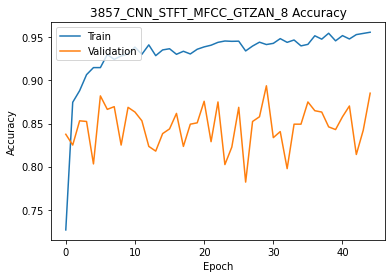

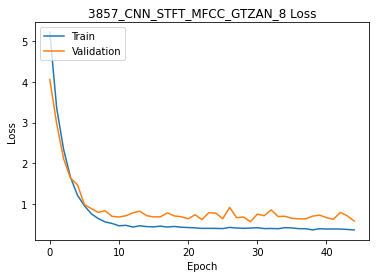

In [57]:
plot_graph(history, name)

In [58]:
best_epoch = 30
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [59]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

200/200 [==============================] - 44s 218ms/step - loss: 0.3414 - categorical_accuracy: 0.9742
Train Loss: 0.34142178297042847
Train Accuracy: 0.9742187261581421
50/50 [==============================] - 11s 214ms/step - loss: 0.5411 - categorical_accuracy: 0.9087
Test Loss: 0.5410709381103516
Test Accuracy: 0.9087499976158142


In [61]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [50]:
classifier = 'svm'
classical_parallel_model(model1, X_train1, model2, X_train2, GTZAN['nGenres'], name, classifier)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 12.2min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 26.8min finished


best score on validation set (accuracy) = 0.9745
best score on training set (accuracy) = 0.9994
best score on test set (accuracy) = 0.9394


### Extended Ballroom

In [65]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MFCC'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [66]:
m = parallel_model(model1, model2, EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "4734_CNN_STFT_MFCC_EXTENDEDBALLROOM_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13_0 (InputLayer)         [(None, 1025, 80, 1) 0                                            
__________________________________________________________________________________________________
conv2d_60_1 (Conv2D)            (None, 1025, 80, 16) 160         input_13_0[0][0]                 
__________________________________________________________________________________________________
batch_normalization_60_2 (Batch (None, 1025, 80, 16) 64          conv2d_60_1[0][0]                
__________________________________________________________________________________________________
activation_60_3 (Activation)    (None, 1025, 80, 16) 0           batch_normalization_60_2[0][0]   
______________________________________________________________

In [67]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
320/320 [==============================] - 1043s 3s/step - loss: 4.2473 - categorical_accuracy: 0.8323 - val_loss: 1.3911 - val_categorical_accuracy: 0.8975
Epoch 2/100
320/320 [==============================] - 1046s 3s/step - loss: 0.9606 - categorical_accuracy: 0.9305 - val_loss: 0.6491 - val_categorical_accuracy: 0.8996
Epoch 3/100
320/320 [==============================] - 1041s 3s/step - loss: 0.4795 - categorical_accuracy: 0.9285 - val_loss: 0.5742 - val_categorical_accuracy: 0.8883
Epoch 4/100
320/320 [==============================] - 1036s 3s/step - loss: 0.3653 - categorical_accuracy: 0.9417 - val_loss: 0.4889 - val_categorical_accuracy: 0.9033
Epoch 5/100
320/320 [==============================] - 1026s 3s/step - loss: 0.3595 - categorical_accuracy: 0.9350 - val_loss: 0.5492 - val_categorical_accuracy: 0.8877
Epoch 6/100
320/320 [==============================] - 1038s 3s/step - loss: 0.3568 - categorical_accuracy: 0.9374 - val_loss: 0.5163 - val_categorical_acc

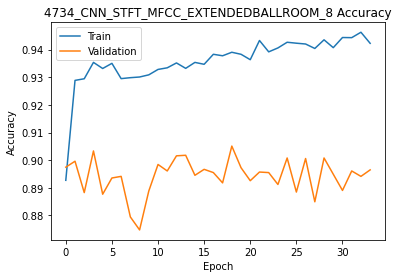

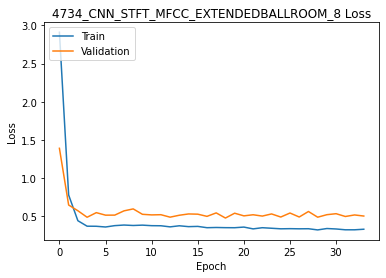

In [68]:
plot_graph(history, name)

In [69]:
best_epoch = 19
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [70]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

799/799 [==============================] - 186s 232ms/step - loss: 0.2905 - categorical_accuracy: 0.9652
Train Loss: 0.29049187898635864
Train Accuracy: 0.9652027487754822
200/200 [==============================] - 46s 231ms/step - loss: 0.4530 - categorical_accuracy: 0.9131
Test Loss: 0.45300400257110596
Test Accuracy: 0.9131183624267578


In [71]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

## STFT + MELSPECTROGRAM

Show pic of STFT and Melspectrogram

### GTZAN

In [14]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [15]:
m = parallel_model(model1, model2, GTZAN['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "5031_CNN_STFT_MELSPECTROGRAM_GTZAN_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7_0 (InputLayer)          [(None, 1025, 80, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30_1 (Conv2D)            (None, 1025, 80, 16) 160         input_7_0[0][0]                  
__________________________________________________________________________________________________
batch_normalization_30_2 (Batch (None, 1025, 80, 16) 64          conv2d_30_1[0][0]                
__________________________________________________________________________________________________
activation_30_3 (Activation)    (None, 1025, 80, 16) 0           batch_normalization_30_2[0][0]   
_______________________________________________________________

In [16]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
80/80 [==============================] - 243s 3s/step - loss: 6.9150 - categorical_accuracy: 0.5974 - val_loss: 4.2054 - val_categorical_accuracy: 0.8398
Epoch 2/100
80/80 [==============================] - 244s 3s/step - loss: 3.8991 - categorical_accuracy: 0.8514 - val_loss: 3.1329 - val_categorical_accuracy: 0.8539
Epoch 3/100
80/80 [==============================] - 245s 3s/step - loss: 2.8404 - categorical_accuracy: 0.8777 - val_loss: 2.3746 - val_categorical_accuracy: 0.8508
Epoch 4/100
80/80 [==============================] - 245s 3s/step - loss: 2.0760 - categorical_accuracy: 0.9081 - val_loss: 1.8180 - val_categorical_accuracy: 0.8766
Epoch 5/100
80/80 [==============================] - 245s 3s/step - loss: 1.5625 - categorical_accuracy: 0.9235 - val_loss: 1.5818 - val_categorical_accuracy: 0.8180
Epoch 6/100
80/80 [==============================] - 246s 3s/step - loss: 1.2314 - categorical_accuracy: 0.9156 - val_loss: 1.1849 - val_categorical_accuracy: 0.8727
Epoc

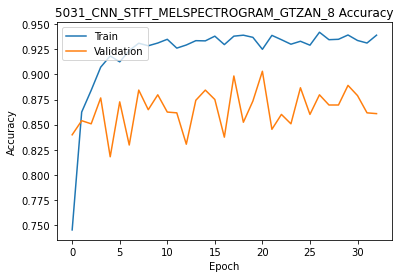

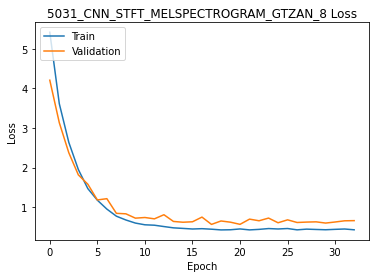

In [17]:
plot_graph(history, name)

In [18]:
best_epoch = 18
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [19]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

200/200 [==============================] - 39s 194ms/step - loss: 0.3708 - categorical_accuracy: 0.9706
Train Loss: 0.3707648515701294
Train Accuracy: 0.9706249833106995
50/50 [==============================] - 10s 195ms/step - loss: 0.5560 - categorical_accuracy: 0.9056
Test Loss: 0.5559943914413452
Test Accuracy: 0.9056249856948853


In [20]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

### Extended Ballroom

In [21]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [22]:
m = parallel_model(model1, model2, EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "5948_CNN_STFT_MELSPECTROGRAM_EXTENDEDBALLROOM_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13_0 (InputLayer)         [(None, 1025, 80, 1) 0                                            
__________________________________________________________________________________________________
conv2d_60_1 (Conv2D)            (None, 1025, 80, 16) 160         input_13_0[0][0]                 
__________________________________________________________________________________________________
batch_normalization_60_2 (Batch (None, 1025, 80, 16) 64          conv2d_60_1[0][0]                
__________________________________________________________________________________________________
activation_60_3 (Activation)    (None, 1025, 80, 16) 0           batch_normalization_60_2[0][0]   
____________________________________________________

In [23]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
320/320 [==============================] - 1038s 3s/step - loss: 4.9608 - categorical_accuracy: 0.8194 - val_loss: 1.8416 - val_categorical_accuracy: 0.8840
Epoch 2/100
320/320 [==============================] - 1032s 3s/step - loss: 1.3261 - categorical_accuracy: 0.9254 - val_loss: 0.8795 - val_categorical_accuracy: 0.8984
Epoch 3/100
320/320 [==============================] - 1025s 3s/step - loss: 0.6565 - categorical_accuracy: 0.9305 - val_loss: 0.6573 - val_categorical_accuracy: 0.8914
Epoch 4/100
320/320 [==============================] - 1023s 3s/step - loss: 0.4656 - categorical_accuracy: 0.9319 - val_loss: 0.6144 - val_categorical_accuracy: 0.8836
Epoch 5/100
320/320 [==============================] - 1023s 3s/step - loss: 0.3920 - categorical_accuracy: 0.9388 - val_loss: 0.4992 - val_categorical_accuracy: 0.9025
Epoch 6/100
320/320 [==============================] - 1024s 3s/step - loss: 0.3797 - categorical_accuracy: 0.9351 - val_loss: 0.5170 - val_categorical_acc

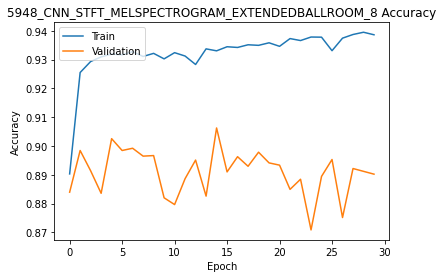

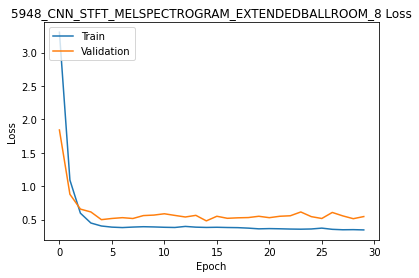

In [24]:
plot_graph(history, name)

In [25]:
best_epoch = 15
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [26]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

799/799 [==============================] - 181s 226ms/step - loss: 0.3011 - categorical_accuracy: 0.9635
Train Loss: 0.30114418268203735
Train Accuracy: 0.9635196328163147
200/200 [==============================] - 46s 231ms/step - loss: 0.4631 - categorical_accuracy: 0.9112
Test Loss: 0.46311673521995544
Test Accuracy: 0.9112398028373718


In [27]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

## MFCC + MELSPECTROGRAM

Show pic of MFCC and Melspectrogram

### GTZAN

In [28]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'MFCC'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [29]:
m = parallel_model(model1, model2, GTZAN['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "6448_CNN_MFCC_MELSPECTROGRAM_GTZAN_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5_0 (InputLayer)          [(None, 20, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16_1 (Conv2D)            (None, 20, 80, 32)   320         input_5_0[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16_2 (Batch (None, 20, 80, 32)   128         conv2d_16_1[0][0]                
__________________________________________________________________________________________________
activation_16_3 (Activation)    (None, 20, 80, 32)   0           batch_normalization_16_2[0][0]   
_______________________________________________________________

In [30]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
80/80 [==============================] - 15s 177ms/step - loss: 7.2657 - categorical_accuracy: 0.4828 - val_loss: 4.0682 - val_categorical_accuracy: 0.7711
Epoch 2/100
80/80 [==============================] - 14s 177ms/step - loss: 3.9081 - categorical_accuracy: 0.7617 - val_loss: 3.2713 - val_categorical_accuracy: 0.7773
Epoch 3/100
80/80 [==============================] - 14s 175ms/step - loss: 3.0415 - categorical_accuracy: 0.7964 - val_loss: 2.5967 - val_categorical_accuracy: 0.7937
Epoch 4/100
80/80 [==============================] - 14s 173ms/step - loss: 2.4028 - categorical_accuracy: 0.8169 - val_loss: 2.0162 - val_categorical_accuracy: 0.8313
Epoch 5/100
80/80 [==============================] - 14s 174ms/step - loss: 1.9199 - categorical_accuracy: 0.8283 - val_loss: 1.6665 - val_categorical_accuracy: 0.8234
Epoch 6/100
80/80 [==============================] - 14s 174ms/step - loss: 1.5368 - categorical_accuracy: 0.8518 - val_loss: 1.3994 - val_categorical_accuracy:

80/80 [==============================] - 14s 174ms/step - loss: 0.4864 - categorical_accuracy: 0.9071 - val_loss: 0.7105 - val_categorical_accuracy: 0.8383
Epoch 50/100
80/80 [==============================] - 14s 175ms/step - loss: 0.4917 - categorical_accuracy: 0.9049 - val_loss: 0.6844 - val_categorical_accuracy: 0.8359
Epoch 51/100
80/80 [==============================] - 14s 174ms/step - loss: 0.5226 - categorical_accuracy: 0.8974 - val_loss: 0.6569 - val_categorical_accuracy: 0.8609
Epoch 52/100
80/80 [==============================] - 14s 173ms/step - loss: 0.4791 - categorical_accuracy: 0.9156 - val_loss: 0.6003 - val_categorical_accuracy: 0.8672
Epoch 53/100
80/80 [==============================] - 14s 174ms/step - loss: 0.4634 - categorical_accuracy: 0.9136 - val_loss: 0.5950 - val_categorical_accuracy: 0.8680
Epoch 54/100
80/80 [==============================] - 14s 174ms/step - loss: 0.4796 - categorical_accuracy: 0.9057 - val_loss: 0.6331 - val_categorical_accuracy: 0.8594

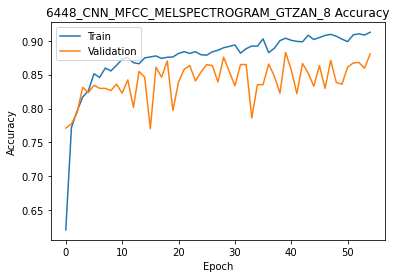

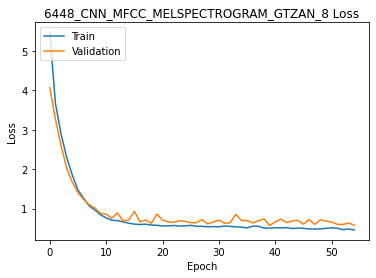

In [31]:
plot_graph(history, name)

In [32]:
best_epoch = 40
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [33]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

200/200 [==============================] - 4s 19ms/step - loss: 0.3449 - categorical_accuracy: 0.9695
Train Loss: 0.3449403643608093
Train Accuracy: 0.969531238079071
50/50 [==============================] - 1s 18ms/step - loss: 0.5565 - categorical_accuracy: 0.8919
Test Loss: 0.5564531087875366
Test Accuracy: 0.8918750286102295


In [34]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

### Extended Ballroom

In [35]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'MFCC'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [36]:
m = parallel_model(model1, model2, EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "2345_CNN_MFCC_MELSPECTROGRAM_EXTENDEDBALLROOM_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11_0 (InputLayer)         [(None, 20, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_40_1 (Conv2D)            (None, 20, 80, 32)   320         input_11_0[0][0]                 
__________________________________________________________________________________________________
batch_normalization_40_2 (Batch (None, 20, 80, 32)   128         conv2d_40_1[0][0]                
__________________________________________________________________________________________________
activation_40_3 (Activation)    (None, 20, 80, 32)   0           batch_normalization_40_2[0][0]   
____________________________________________________

In [37]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
320/320 [==============================] - 58s 176ms/step - loss: 5.3931 - categorical_accuracy: 0.6972 - val_loss: 2.2487 - val_categorical_accuracy: 0.8667
Epoch 2/100
320/320 [==============================] - 56s 175ms/step - loss: 1.9968 - categorical_accuracy: 0.8377 - val_loss: 1.2002 - val_categorical_accuracy: 0.8744
Epoch 3/100
320/320 [==============================] - 56s 176ms/step - loss: 1.0926 - categorical_accuracy: 0.8586 - val_loss: 0.7655 - val_categorical_accuracy: 0.8865
Epoch 4/100
320/320 [==============================] - 56s 176ms/step - loss: 0.7549 - categorical_accuracy: 0.8644 - val_loss: 0.6261 - val_categorical_accuracy: 0.8843
Epoch 5/100
320/320 [==============================] - 56s 176ms/step - loss: 0.6276 - categorical_accuracy: 0.8688 - val_loss: 0.5532 - val_categorical_accuracy: 0.8857
Epoch 6/100
320/320 [==============================] - 57s 177ms/step - loss: 0.5803 - categorical_accuracy: 0.8670 - val_loss: 0.5538 - val_categoric

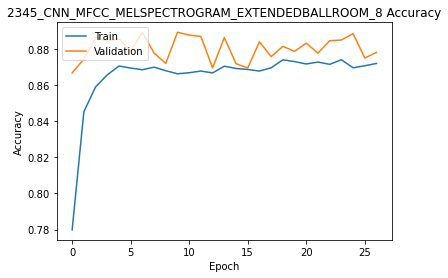

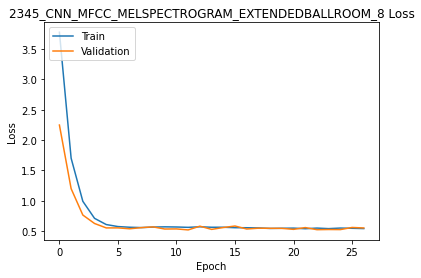

In [38]:
plot_graph(history, name)

In [39]:
best_epoch = 12
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [40]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

799/799 [==============================] - 15s 19ms/step - loss: 0.3954 - categorical_accuracy: 0.9282
Train Loss: 0.39543601870536804
Train Accuracy: 0.9282135367393494
200/200 [==============================] - 4s 19ms/step - loss: 0.5013 - categorical_accuracy: 0.8912
Test Loss: 0.5012863874435425
Test Accuracy: 0.8912022709846497


In [41]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

# Final Results

In [47]:
MODELS_PATH = os.path.join(os.getcwd(), 'models', 'models.csv')
MODELS = pd.read_csv(MODELS_PATH).set_index("Model Name")
MODELS = MODELS.sort_values('Test Accuracy', ascending = False)
MODELS = MODELS[MODELS['Split'].isin([5, 8, 10])]
MODELS

,Method,Dataset,Feature,Split,Test Accuracy,Test Loss,Train Accuracy,Train Loss,Best Epoch,Validation Accuracy,Validation Loss,Training Accuracy,Training Loss
Model Name,,,,,,,,,,,,,
4734_CNN_STFT_MFCC_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,"STFT, MFCC",8,0.913118,0.453004,0.965203,0.290492,19,0.905088,0.478700,0.939035,0.352757
5948_CNN_STFT_MELSPECTROGRAM_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,"STFT, MELSPECTROGRAM",8,0.911240,0.463117,0.963520,0.301144,15,0.906262,0.480903,0.933066,0.382799
3857_CNN_STFT_MFCC_GTZAN_8,CNN,GTZAN,"STFT, MFCC",8,0.908750,0.541071,0.974219,0.341422,30,0.893750,0.562724,0.941602,0.405900
5031_CNN_STFT_MELSPECTROGRAM_GTZAN_8,CNN,GTZAN,"STFT, MELSPECTROGRAM",8,0.905625,0.555994,0.970625,0.370765,18,0.898438,0.568121,0.938086,0.447174
3375_CNN_STFT_EXTENDEDBALLROOM_5,CNN,ExtendedBallroom,STFT,5,0.903808,0.492371,0.945140,0.365856,39,0.910770,0.472410,0.926570,0.398633
7137_CNN_STFT_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,STFT,8,0.903413,0.473348,0.947432,0.318092,53,0.895499,0.492155,0.923329,0.383254
6968_CNN_STFT_EXTENDEDBALLROOM_10,CNN,ExtendedBallroom,STFT,10,0.894664,0.462838,0.934463,0.352995,48,0.891046,0.484993,0.903867,0.443369
5461_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_5,CNN,ExtendedBallroom,MELSPECTROGRAM,5,0.894289,0.490980,0.930173,0.379099,75,0.900751,0.461575,0.866291,0.575260
6448_CNN_MFCC_MELSPECTROGRAM_GTZAN_8,CNN,GTZAN,"MFCC, MELSPECTROGRAM",8,0.891875,0.556453,0.969531,0.344940,40,0.882812,0.568622,0.903711,0.500308


### Results of Combining CNNs with different inputs

# Test

Use recent songs and test